In [100]:
import warnings
warnings.filterwarnings('ignore')

## Packages Used for this Talk

In [98]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm

from ipywidgets import interact, interactive, FloatSlider, Dropdown, IntSlider, FloatLogSlider, Checkbox, GridBox, VBox, HBox, Layout

## Demo: What Do Error Bars Represent?

In [212]:
def error_bars_demo(mean=0., std=1., n=100., errorbar='std', distribution='norm', show_dist=False, show_hist=False, seaborn_plot=None, ):
    n = int(n)
    x = np.linspace(-20, 20, 1000)
    if distribution == 'norm':
        dist = stats.norm(mean, std)
    else:
        dist = stats.gamma(3, mean, std)
    data = dist.rvs(n)
    mean = dist.mean() if not show_hist else np.mean(data)
    std = dist.std()   if not show_hist else np.std(data)
    pdf = dist.pdf(x) #if source=='dist' else 
    sem = np.std(data) / np.sqrt(n - 1)
    
    
    
    if not errorbar or errorbar == 'std':
        error_range = np.linspace(mean - std, mean + std, 200)
    elif errorbar == '2std':
        error_range = np.linspace(mean - 2 * std, mean + 2 * std, 200)
    elif errorbar == '95% IQI':
        if not show_hist:
            error_range = np.linspace(*dist.interval(.95), num=600) 
        else:
            error_range = np.linspace(*np.percentile(data, [2.5, 97.5]), num=600)
    elif errorbar == 'sem':
        error_range = np.linspace(mean - sem, mean + sem, 600)
    elif errorbar == '2sem':
        error_range = np.linspace(mean - 2 * sem, mean + 2 * sem, 600)
    elif errorbar == '95% CI':
        boot_ci = 500
        bootstrapped_data = np.random.choice(data, size=(len(data), boot_ci))
        bootstrapped_means = np.mean(bootstrapped_data, axis=0)
        assert len(bootstrapped_means) == boot_ci
        error_range = np.linspace(*np.percentile(bootstrapped_means, [2.5, 97.5]), num=600)
        
        
    error_pdf = dist.pdf(error_range)
    
    
    # Plots
    fig = plt.figure(figsize=(15, 9))
    ax1 = plt.subplot2grid((3, 4), (0, 0), rowspan=3, fig=fig);
    ax2 = plt.subplot2grid((3, 4), (0, 1), rowspan=1, colspan=2, fig=fig)
    ax3 = plt.subplot2grid((3, 4), (0, 3), rowspan=3, fig=fig)
    ax4 = plt.subplot2grid((3, 4), (1, 1), rowspan=1, colspan=2, fig=fig)
    ax5 = plt.subplot2grid((3, 4), (2, 1), rowspan=1, colspan=2, fig=fig)
    ax_lims = [-3, 7]
    
    ## Bar Chart, with Error Bars
#     ax1.bar(['Control'], mean, alpha=0.3, width=0.2)
#     ax1.errorbar(x=0, y=mean, yerr=error_range.max() - mean, fmt='ko', capsize=10)
    ax1.errorbar(x=0, y=mean, yerr=[[mean - error_range.min()], [error_range.max() - mean]], fmt='ko', capsize=10)
    ax1.set(xlim=[-1, 1], ylim=ax_lims, xticks=[])
    ax1.hlines(0, *ax_lims, linestyle='dotted', color='black')
    
    
    ## Distribution, with Error Bar Coverage Highlighted 
    if show_dist:
        ax2.plot(x, pdf, label='PDF of Normal Distribution', linewidth=3);
        ax2.errorbar(x=mean, y=0.1 * np.max(pdf), xerr=[[mean - error_range.min()], [error_range.max() - mean]], fmt='ko', capsize=10)
        ax2.fill_between(error_range, error_pdf, color='red', alpha=0.3, label='1 Standard Deviation')
        ax2.text(mean, 0.5 * np.max(pdf), f"{(np.diff(error_range) * error_pdf[:-1]).sum() / (np.diff(x) * pdf[:-1]).sum():.1%}", horizontalalignment='center')
        ax2.vlines(dist.mean(), *ax2.get_ylim(), linestyle='dotted')
    ax2.set(yticklabels=[], xlim=ax_lims, yticks=[])
    
    ## Seaborn's Representation
    if seaborn_plot:
        # Instead of the figure-level sns.catplot(kind='strip'), use the equivelent, axis-level sns.stripplot() to put it inside the existing figure.
        distribution_plots = {'strip': sns.stripplot, 'swarm': sns.swarmplot, 'box': sns.boxplot, 'violin': sns.violinplot, 'boxen': sns.boxenplot, 'point': sns.pointplot, 'bar': sns.barplot}
        if seaborn_plot in ['boxen', 'violin']:
            distribution_plots[seaborn_plot](y=data, ax=ax3, width=2.5, color=sns.color_palette()[1]);
        else:
            distribution_plots[seaborn_plot](y=data, ax=ax3, color=sns.color_palette()[1]);
    ax3.hlines(0, *ax_lims, linestyle='dotted', color='black')
    ax3.set(ylim=ax_lims, xticks=[])
    
    ## Show Data Distribution
    if show_hist:
        if errorbar == '95% CI':
            for boot in bootstrapped_data.T[::20]:  #No need to show them all...
                sns.kdeplot(boot, alpha=0.2, color=sns.color_palette()[0], ax=ax4)
            ax4.vlines(bootstrapped_means, *ax4.get_ylim(), alpha=0.02, color='black')
        else:
            sns.distplot(data, ax=ax4)
            ax4.vlines(np.mean(data), *ax4.get_ylim(), linestyle='dotted')
        
        ## 
        if errorbar == 'sem' or errorbar == '2sem':
            dist_derived = stats.norm(np.mean(data), sem)
            pdf_derived = dist_derived.pdf(x)
            ax5.plot(x, pdf_derived)
            ax5.fill_between(error_range, dist_derived.pdf(error_range), color='red', alpha=0.3)
        elif errorbar == '95% CI':
            dist_bootstrapped = stats.norm(np.mean(bootstrapped_means), np.std(bootstrapped_means))
            ax5.plot(x, dist_bootstrapped.pdf(x))
            err_range = np.linspace(*dist_bootstrapped.interval(.95), num=200)
            ax5.fill_between(err_range, dist_bootstrapped.pdf(err_range), color='red', alpha=0.3)
        
#         ax5.vlines(bootstrapped_means, *ax4.get_ylim(), alpha=0.02, color=sns.color_palette()[3])
    ax4.set(xlim=ax_lims, yticks=[])
    ax5.set(xlim=ax_lims, yticks=[])
    

h1 = interactive(error_bars_demo,
    mean = FloatSlider(0.5, min=-3, max=3),
    std = FloatSlider(1, min=0.01, max=4),
    n = IntSlider(40, min=6, max=400),
    errorbar = Dropdown(options=['', 'std', '2std', '95% IQI', 'sem', '2sem', '95% CI']),
    show_dist = Checkbox(False),
    distribution = Dropdown(options=['norm', 'gamma']),
    show_hist = Checkbox(False),
    seaborn_plot = Dropdown(options=[None, 'strip', 'swarm', 'box', 'violin', 'boxen', 'point', 'bar']),
)

VBox([HBox([VBox(h1.children[:3]), VBox(h1.children[3:6]), VBox(h1.children[6:8])]), h1.children[-1]])

## Applying Confidence Intervals and Estimators in Seaborn

In [178]:
data = stats.norm(2, 3).rvs(40)
data[:5]

array([ 0.41856149,  2.9118273 , -0.03760027,  5.5251771 ,  2.17532071])

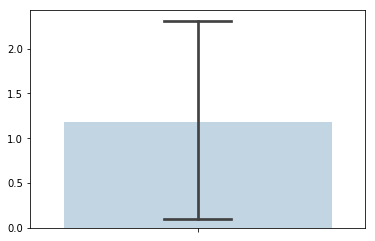

In [173]:
sns.barplot(y=data, capsize=0.2, alpha=.3);

## Further Directions: The "Posterior Prediction" Error Bar

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [std, mean]
Sampling 2 chains: 100%|██████████████████████████████████████████████████████| 7000/7000 [00:03<00:00, 1800.51draws/s]


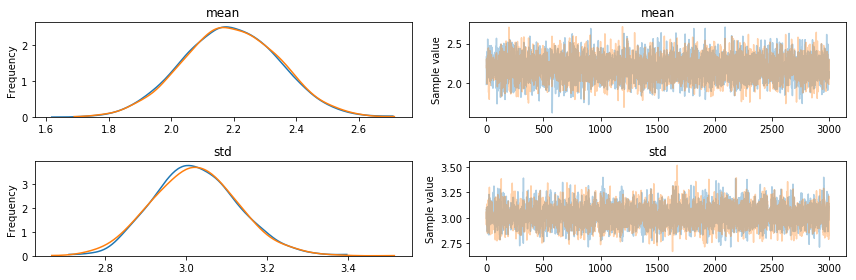

In [175]:
data = stats.norm(2, 3).rvs(400)

with pm.Model():
    mean = pm.Uniform('mean', lower=-10, upper=10)
    std = pm.HalfNormal('std', sd=5)
    y_observed = pm.Normal('y_observed', mu=mean, sd=std, observed=data)

    trace = pm.sample(3000, cores=2, )
    pm.traceplot(trace);

### Compare Mean Posterior Distribution to Bootstrapped Means

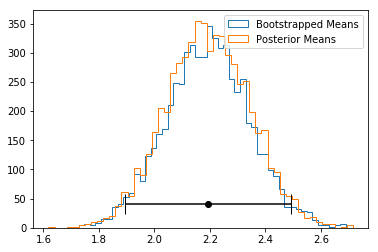

In [176]:
plt.hist(np.random.choice(data, size=(6000, len(data))).mean(axis=1), bins=50, histtype='step', label='Bootstrapped Means');
plt.hist(trace.mean, bins=50, histtype='step', label='Posterior Means')

mean = trace.mean.mean()
err1, err2 = np.percentile(trace.mean, [2.5, 97.5])
plt.errorbar(y=40, x=mean, xerr=[[mean - err1], [err2 - mean]], capsize=10, fmt='o', color='black')
plt.legend();